In [1]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor               
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers 

import matplotlib
matplotlib.rcParams['font.family'] = 'serif'

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in numpy
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cgpu')

print("The neural network will be trainied on", device)

if device == torch.device('cuda'): 
    print(torch.cuda.get_device_name(0))

The neural network will be trainied on cuda
NVIDIA GeForce RTX 3090


In [2]:
# Define the simulation parameters
x_min=0
x_max=1
y_min=0
y_max=1

def rho(input):
    x = input[:,0]
    y = input[:,1]
    return torch.where((x > 0.3) & (x < 0.7) & (y > 0.65) & (y < 0.7), 1.0, 
                    torch.where((x > 0.3) & (x < 0.7) & (y > 0.3) & (y < 0.35), -1.0, 0.0))


In [ ]:
#Lets define a u_NN

class u_NN(nn.Module):
    
    def __init__(self, layers_list):
        
        super().__init__()

        self.depth = len(layers_list)

        self.loss_function = nn.MSELoss(reduction="mean")
    
        self.activation = nn.Tanh() #This is important, ReLU wont work

        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])

        for i in range(self.depth-1):
      
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #xavier normalization of weights
      
          nn.init.zeros_(self.linears[i].bias.data) #all biases set to zero 

    def Convert(self, x): #helper function
        
        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)
  
    def forward(self, x):
        
        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        a = self.linears[-1](a)

        return a

    def loss_x_bc(self, x_bc):
        #This is similar to a Supervised Learning

        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(np.zeros_like(x_bc))) #L2 loss

        return l_bc

    def loss_y_bc(self, y_bc):
        #This is similar to a Supervised Learning

        l_bc = self.loss_function(self.forward(self.Convert(y_bc)), self.Convert(np.zeros_like(y_bc))) #L2 loss

        return l_bc

    def loss_pde(self, x_pde):
        # We will pass x_train_final here. 
        # Note that we do not have U_pde (labels) here to calculate loss. This is not Supervised Learning. 
        # Here we want to minimize the residues. So, we will first calculate the residue and then minimize it to be close to zero.

        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone() ##VERY IMPORTANT
    
        x_pde_clone.requires_grad = True #enable Auto Differentiation

        NN = self.forward(x_pde_clone) #Generates predictions from u_NN

        NNx_NNy = torch.autograd.grad(NN, x_pde_clone,self.Convert(torch.ones([x_pde_clone.shape[0],1])),retain_graph=True, create_graph=True)[0] #Jacobian of dx and dt

        NNxx_NNyy = torch.autograd.grad(NNx_NNy,x_pde_clone, self.Convert(torch.ones(x_pde_clone.shape)), create_graph=True)[0] #Jacobian of dx2, dt2

        NNxx = NNxx_NNyy[:,[0]] #Extract only dx2 terms
        NNyy = NNxx_NNyy[:,[1]] #Extract only dy2 terms

        residue = NNxx + NNyy + rho(x_pde_clone) # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue

        # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue 

        zeros = self.Convert(torch.zeros(residue.shape[0],1))

        l_pde = self.loss_function(residue, zeros) #L2 Loss

        return l_pde
    
    def total_loss(self, x_bc, u_bc, x_pde): #Combine both loss
        # l_bc = self.loss_bc(x_bc, u_bc)
        # l_ic = self.loss_ic(x_ic, u_ic)
        l_pde = self.loss_pde(x_pde)
        return l_pde #this HAS to be a scalar value for auto differentiation to do its thing.


In [32]:
EPOCHS = 30000
initial_lr = 0.001
layers_list = [2, 32, 64, 64, 32, 1]
#batch_size = 32

# Instantiate a model

PINN = u_NN(layers_list).to(device)
print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(), lr=initial_lr,amsgrad=False)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

history = pd.DataFrame(columns=["Epochs","Learning_Rate", "IC_Loss","BC_Loss","PDE_Loss","Total_Loss","Test_Loss"])


u_NN(
  (loss_function): MSELoss()
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [33]:
N_bc = 1000 #Number of points on BC
N_pde = 30000 #Number of points on PDE domain (Collocation Points)


In [34]:
#****** Training ******#

print("Training Physics Informed Neural Network...")

Epoch = []
Learning_Rate = []
IC_Loss = []
BC_Loss = []
PDE_Loss = []
Total_Loss = []
Test_Loss = []

for i in tqdm_notebook(range(EPOCHS)):
    if i==0:
        print("Epoch \t Learning_Rate \t IC_Loss \t BC_Loss \t PDE_Loss \t Total_Loss")
        
    xy_bulk = np.random.random((N_pde,2))

    xy_x_bc = np.zeros((N_bc * 2, 2))
    xy_x_bc[N_bc:,0] = 1.0
    xy_x_bc[:,1] = np.random.random(N_bc * 2)

    xy_y_bc = np.zeros((N_bc * 2, 2))
    xy_y_bc[N_bc:,1] = 1.0
    xy_y_bc[:,0] = np.random.random(N_bc * 2)
    
    # l_ic = PINN.loss_ic(X_ic_samples,U_ic_samples)
    l_x_bc = PINN.loss_x_bc(xy_x_bc)
    l_y_bc = PINN.loss_y_bc(xy_y_bc)
    l_pde = PINN.loss_pde(xy_bulk)
    loss = l_x_bc + l_y_bc + l_pde
    # loss = PINN.total_loss(X_ic_samples,U_ic_samples,X_bc_samples,U_bc_samples, X_train_final)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if i%100 == 0: #print losses and step the exponential learning rate.
                
        with torch.no_grad():
            # test_loss = PINN.loss_bc(x_test,u_test) #Here we are using loss_bc method as a helper function to calculate L2 loss
            
            Epoch.append(i)
            Learning_Rate.append(scheduler.get_last_lr()[0])
            IC_Loss.append(l_x_bc.detach().cpu().numpy())
            BC_Loss.append(l_y_bc.detach().cpu().numpy())
            PDE_Loss.append(l_pde.detach().cpu().numpy())
            Total_Loss.append(loss.detach().cpu().numpy())
            # Test_Loss.append(test_loss.detach().cpu().numpy())

            if i%1000 ==0:
               print(i,'\t',format(scheduler.get_last_lr()[0],".4E"),'\t',format(l_x_bc.detach().cpu().numpy(),".4E"),'\t',format(l_y_bc.detach().cpu().numpy(),".4E"),'\t',
                  format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"))
 
        scheduler.step()

print("Completed!!")

Training Physics Informed Neural Network...


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 	 Learning_Rate 	 IC_Loss 	 BC_Loss 	 PDE_Loss 	 Total_Loss
0 	 1.0000E-03 	 1.0279E-02 	 1.5552E-02 	 4.8598E-02 	 7.4429E-02


/usr/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2000, 2])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([30000, 1])) that is different to the input size (torch.Size([30000, 30000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1000 	 8.5973E-04 	 5.7109E-07 	 5.0116E-07 	 4.1108E-02 	 4.1109E-02
2000 	 7.3914E-04 	 5.3373E-07 	 4.9795E-07 	 3.8869E-02 	 3.8870E-02
3000 	 6.3546E-04 	 2.2521E-07 	 1.7018E-07 	 3.9542E-02 	 3.9542E-02
4000 	 5.4632E-04 	 1.2105E-05 	 1.2328E-05 	 3.9519E-02 	 3.9543E-02
5000 	 4.6969E-04 	 1.5021E-06 	 1.6022E-06 	 3.8534E-02 	 3.8537E-02
6000 	 4.0381E-04 	 2.7210E-07 	 2.9621E-07 	 3.9336E-02 	 3.9336E-02
7000 	 3.4717E-04 	 1.3039E-06 	 6.6907E-07 	 3.9333E-02 	 3.9335E-02
8000 	 2.9847E-04 	 6.7767E-07 	 1.2538E-06 	 4.0940E-02 	 4.0942E-02
9000 	 2.5660E-04 	 3.0212E-07 	 4.4358E-07 	 3.9934E-02 	 3.9934E-02


KeyboardInterrupt: 

In [28]:
xy_grid = np.array(np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100)))
xy_grid_in = xy_grid.T.reshape(-1, 2)

u_NN_results = PINN.forward(torch.tensor(xy_grid_in).to(device)).detach().cpu().numpy()
u_NN_results = u_NN_results.reshape(100, 100)


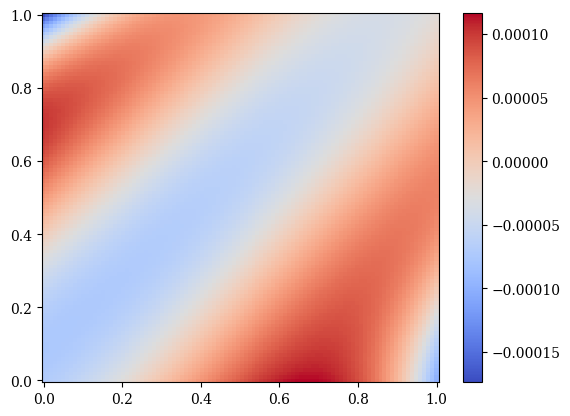

In [30]:
plt.pcolor(xy_grid[0], xy_grid[1], u_NN_results, cmap='coolwarm')
plt.colorbar()